# HW6: Github Demo & Function Comparison

### Author: Victoria Boatwright 
### Collaborator: Grant Meiners

In [37]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr 
import datetime as dt 

import scipy 
from scipy import signal
import netCDF4

# for reading CDF file: 
import cdflib 

plt.rcParams.update({'font.size': 16})

In [38]:
path = 'C:\\Users\\vboat\\OneDrive\\Documents\\SIO\\fall23\\SIO221\\sioc221a\\week7\\' # windows is stupid sometimes
file = 'class10_record_netcf.cdf'
fn = path+file

In [39]:
cdf = cdflib.CDF(fn)
cdf.cdf_info()


CDFInfo(CDF=WindowsPath('C:/Users/vboat/OneDrive/Documents/SIO/fall23/SIO221/sioc221a/week7/class10_record_netcf.cdf'), Version='3.7.0', Encoding=6, Majority='Column_major', rVariables=[], zVariables=['data', 'time'], Attributes=[], Copyright='\nCommon Data Format (CDF)\nhttps://cdf.gsfc.nasa.gov\nSpace Physics Data Facility\nNASA/Goddard Space Flight Center\nGreenbelt, Maryland 20771 USA\n(User support: gsfc-cdf-support@lists.nasa.gov)\n', Checksum=False, Num_rdim=0, rDim_sizes=[], Compressed=False, LeapSecondUpdate=None)

In [40]:
data = cdf.varget('data')[0]
time = cdf.varget('time')[0]

print(cdf.varinq('time'))
print(cdf.varinq('data'))

# seems like no information about time variable, nor the data variable ....

VDRInfo(Variable='time', Num=1, Var_Type='zVariable', Data_Type=45, Data_Type_Description='CDF_DOUBLE', Num_Elements=1, Num_Dims=1, Dim_Sizes=[16000], Sparse='No_sparse', Last_Rec=0, Rec_Vary=True, Dim_Vary=[-1], Compress=0, Pad=array([-1.e+30]), Block_Factor=0)
VDRInfo(Variable='data', Num=0, Var_Type='zVariable', Data_Type=45, Data_Type_Description='CDF_DOUBLE', Num_Elements=1, Num_Dims=1, Dim_Sizes=[16000], Sparse='No_sparse', Last_Rec=0, Rec_Vary=True, Dim_Vary=[-1], Compress=0, Pad=array([-1.e+30]), Block_Factor=0)


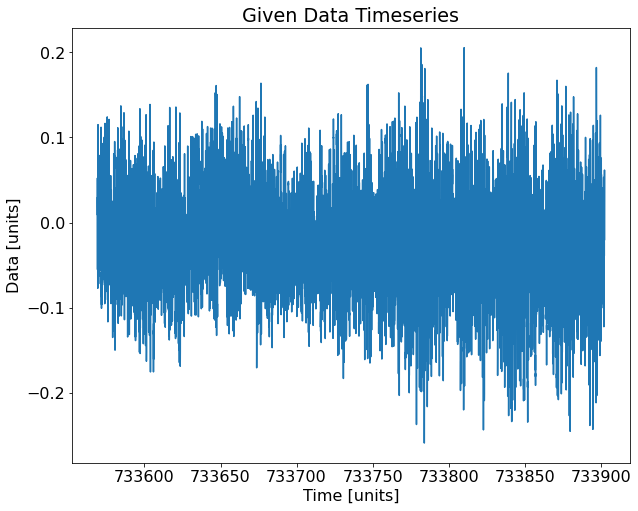

In [41]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(time,data)
ax.set(xlabel='Time [units]',ylabel='Data [units]', title='Given Data Timeseries')
plt.show()


In [42]:
N = len(data)

# size of t_segments - arbitrary
tlen = int(N/10)
# sampling frequency 
deltat = np.diff(time) 

step = np.nanmean(deltat) # step size 
Nyq = 1/(2*step) # Nyquist frequency
period = step*N # this is the entire period 
df = 1/period # fundamental frequency

In [43]:
# how long is each segment? 

segtime = time[tlen]-time[0]
print(f'{segtime} [time units]')


33.33333333337214 [time units]


In [44]:
# function for windowing  

def unknown_windowing(time,data,tseg=int): 
    # this function will return segmented arrays (of size [#segments,#N samples of data in each segment]) from a dataset with an associated time vector 
    # time: full time dataset (in datenumbers/integers )
    # data: full dataset of interest 
    # tsegs: the number of datapoints  desired in your segmenting [ in days ]
    # deltat: the sample spacing between your datapoints [in minutes]
    
    # returns: 
    # time_segs: segments with their original time stamps associated 
    # data_segs: segmented data as an array of [#segments,#N samples of data in each segment]

    import numpy as np 

    # number of tseg intervals encompassed in full dataset
    intervals = int(len(time)/tseg)
    # with 50% overlaps, it will be doubled but 1 less (because start 50% and end 50%)
    cycles = (intervals*2)-1

    num_samples = int(np.floor(len(time)/cycles)) # number of samples in each window 
    

    # can make arrays the correct size because we know how many 10 min samples will be in 60 days 
    # each array = (segment num, data within segment) 
    data_segs = np.zeros((cycles,num_samples))
    time_segs = np.zeros((cycles,num_samples))

    ind = 0
    jump = int(num_samples/2); 
    for nn in np.arange(0,cycles): 
        # looping through each segment in which we will save data 
        data_segs[nn,:] = data[ind:ind+num_samples]
        time_segs[nn,:] = time[ind:ind+num_samples]
        
        # now add to the ind (start index) and jump (number of samples in the segment = 8640)
        ind = ind + jump

    return time_segs,data_segs
    

In [45]:
# function for fft and spectra analysis 

def fft_analysis(data,time,demean=1,detrend=1,hanning=1,all_pars=0):
    # specifications for inputs: 
    # data_array should be size = (segments,data_in_segment); each data_in_segment column should be the same length
    # time array = should be the same size as data_array, could adapted for just a 1D vector. 
    # aka: you must window properly before using this function 
    # then, selecting whether to demean, detrend, hanning window, etc. 

    # returns: 
    # freqs: frequency array associated with spectrum/FFT
    # avg_fft: average fourier transform to plot (real & complex)
    # tot_amp: averaged spectrum 
    # err_low, err_high = high and low errors of dataset 

    import numpy as np 
    import matplotlib.pyplot as plt
    import xarray as xr 
    import datetime as dt 
    import scipy 
    from scipy import fft 
    from scipy import stats 
    
    
    # all segment lengths should be the same 
    N = len(data[0,:])  # == num_samples in each _window_
    deltat = np.diff(time)
    step = np.nanmean(deltat) # step size (in days)
    Nyq = 1/(2*step) # Nyquist frequency
    period = step*N # this is the entire segment period (in days)
    df = 1/period # fundamental frequency
    segs = len(data[:,0]) # total number of segment 
    M = segs
    
    # start workflow: analyze each segment individually 

    # fft & spectra of interest to be averaged 
    fft_oi = np.zeros((segs,N)) # real+complex FFT 
    amp_oi = np.zeros((segs,int(N/2))) # real spectra 
    
    # loop through segments
    for nn in np.arange(0,segs):
        segment = data[nn,:]
        segtime = time[nn,:]
    
        # demean & detrend 
    
        # calculate mean and linear trend 
        AA = np.array([np.ones(N), segtime]).T
        x = np.dot(np.linalg.inv(np.dot(AA.T, AA)), np.dot(AA.T, segment))
        mean = x[0]; trend = x[1]

        if demean==1: 
            segment = segment-mean # demean by calculated mean 
        
        if detrend==1: 
            segment = segment-trend*segtime # detrend from calculated trend
        
        if hanning==1: 
            # hanwin = np.cos(np.pi*segtime / period)**2 # calculate hanning window - unreliable: you want an exactly centered hanning window, so use a known independent variable
            x = np.linspace(-0.5, 0.5, N) # specify known Hanning domain
            hanwin = (np.cos(x*np.pi))**2 # Hanning values
            segment = segment*hanwin*np.sqrt(8/3) # normalize hanning window by sqrt(8/3)
            
        # compute each segment spectrum 
        # fourier transform
        fft = scipy.fft.fft(segment); 
        freq = scipy.fft.fftfreq(N,step); freq = scipy.fft.fftshift(freq); real_freq = freq[freq>=0]
        fftplot = scipy.fft.fftshift(fft)
        norm_fft = 1.0/N * np.abs(fftplot) # normalizing shifted FFT 
    
        r_idx = np.nonzero(freq>=0)
        amp = (norm_fft[r_idx])**2 # only selecting >0 to ignore complex (symmetric about x=0) - then square for amp

        # do the steps for the spectrum: 
        # normalization already done above
        amp = amp*2 # account for discarded redundant complex FFT coefficients 
        amp = amp/df # spectrum is normalized by fundamental freq
        
        fft_oi[nn,:] = norm_fft
        amp_oi[nn,:] = amp
    
        # inner loop parsevals (if desired)
        if all_pars == 1: 
            print(f"data variance & fft variance: {np.nanvar(segment):.04f} and {(np.sum(amp)*df):.04f}")

    avg_fft = np.nanmean(fft_oi,axis=0)
    tot_amp = np.nanmean(amp_oi,axis=0)
    
    # parseval's check : 
    print(f'Check Parsevals - data variance equals integral of spectrum?')
    print(f'Data variance / spectrum integration: {(np.nanvar(data) / (np.sum(tot_amp)*df) ): 0.4f} ')
    
    nu = 2*M # degrees of freedom 
    top = 1-0.05/2; bot = 0.05/2 
    err_low = nu/(scipy.stats.chi2.ppf(top, nu)); err_high = nu/(scipy.stats.chi2.ppf(bot, nu))
    
    return real_freq, avg_fft, tot_amp, err_low, err_high

In [46]:
# grant's function for spectra 

def spectrum(data, time, interval, nsegs=1, detrend=True, Hanning=True):
    '''
    This function is used to make a spectrum given a time-series dataset and the time interval between samples
    in the dataset.

    Arguments:
        data (array) : A 1-d data array of which to have the spectrum computed
        time  (array) : A 1-d time array corresponding to the data array
        interval (float) : Time interval between samples in data
        nsegs (integer) : Number of segments to calculate over
        detrend (boolean) : Whether the data should be detrended before the spectrum is found
        Hanning (boolean) : Whether a Hanning window should be applied to the data before the spectrum is found

    Returns:
        spectrum (array) : A 1-d array containing the spectral values of the input data, in units (data units)
                            squared per frequency (cycles per time interval unit)
        f_range_pos (array) : A 1-d array containing the frequency values corresponding to each spectral value,
                            in units of cycles per time interval unit
    '''
    import numpy as np
    import scipy.signal as signal
    
    points_per_segment = len(data)/nsegs
    if nsegs > 1:
        segs = np.empty(nsegs, dtype=object)
        index = np.arange(0, nsegs/2, 0.5)
        for i in index:
            j = int(np.floor(points_per_segment)*i)
            k = int(np.floor(points_per_segment)*(i+1))
            if i == nsegs-1:
                k = -1
            segs[int(2*i)] = np.array([time[j:k], data[j:k]])
            
        spectra = np.empty(len(segs), dtype=object)
        detrended = []
        for i in range(len(segs)):
            N = len(segs[i][1])
            f_range = np.fft.fftfreq(N, d=interval) #creating an array of frequencies
            f_range_pos = f_range[(f_range >= 0)] #creating an array of positive frequencies
            delta_f = 1/(N*interval) #finding the fundamental frequency

            x = np.linspace(-0.5, 0.5, N) # Hanning domain
            hanning = np.sqrt(8/3)*((np.cos(x*np.pi))**2) # Hanning values

            # various different ffts to be taken, depending on the detrend and Hanning conditions
            if detrend and Hanning:
                fft=np.fft.fft(hanning*signal.detrend(segs[i][1])) #applying Hanning window and detrend
                detrended = np.append(detrended, hanning*signal.detrend(segs[i][1]))
            elif detrend and Hanning == False:
                fft = np.fft.fft(signal.detrend(segs[i][1])) #applying just detrend
                detrended = np.append(detrended, signal.detrend(segs[i][1]))
            elif detrend == False and Hanning:
                fft = np.fft.fft(hanning*segs[i][1]) #applying just Hanning window
                detrended = np.append(detrended, hanning*segs[i][1])
            else: 
                fft = np.fft.fft(data) #just FFTing raw data
                detrended = np.append(detrended, segs[i][1])
            normal = np.abs(fft[(f_range >= 0)])/N #normalize and only use positive freqs
            spectra[i]= 2*(normal**2)/delta_f #spectra formula and multiply by 2 to account for negative frequencies
        spectrum = np.mean(spectra)
    elif nsegs == 1:
        N = len(data)
        f_range = np.fft.fftfreq(N, d=interval) #creating an array of frequencies
        f_range_pos = f_range[(f_range >= 0)] #creating an array of positive frequencies
        delta_f = 1/(N*interval) #finding the fundamental frequency
    
        x = np.linspace(-0.5, 0.5, N) # Hanning domain
        hanning = np.sqrt(8/3)*((np.cos(x*np.pi))**2) # Hanning values

        # various different ffts to be taken, depending on the detrend and Hanning conditions
        if detrend and Hanning:
            fft=np.fft.fft(hanning*signal.detrend(data)) #applying Hanning window and detrend
        elif detrend and Hanning == False:
            fft = np.fft.fft(signal.detrend(data)) #applying just detrend
        elif detrend == False and Hanning:
            fft = np.fft.fft(hanning*data) #applying just Hanning window
        else: 
            fft = np.fft.fft(data) #just FFTing raw data

        normal = np.abs(fft[(f_range >= 0)])/N #normalize and only use positive freqs
        spectrum = 2*(normal**2)/delta_f #spectra formula and multiply by 2 to account for negative frequencies
        detrended=data
    print(f'The variance of the dataset is {np.nanvar(detrended):.5f} and the integral of the spectrum is {np.nansum(spectrum)*delta_f:.5f}.')
    return spectrum, f_range_pos



In [47]:
# windowing with unknown dataset: 
tsegs, dsegs = unknown_windowing(time,data,tseg=tlen)

# grant's funtion 
[spec, frequency] = spectrum(data,time,step,nsegs=19)

# victoria's function 
[f,fft,amp,erl,erh] = fft_analysis(dsegs,tsegs,demean=1,detrend=1,hanning=1,all_pars=0)





The variance of the dataset is 0.00276 and the integral of the spectrum is 0.00276.
Check Parsevals - data variance equals integral of spectrum?
Data variance / spectrum integration:  1.0306 


Looks like both of our functions confirm Parseval's - the data variance is equal to the integral of the spectrum! 

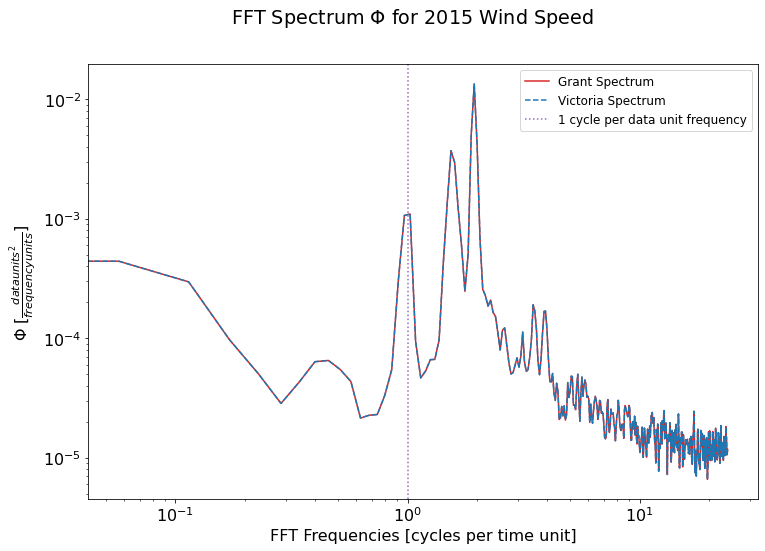

In [49]:
# plot comparing spectra 

fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.suptitle(r'FFT Spectrum $\Phi$ for 2015 Wind Speed')
ax.plot(frequency,spec,label='Grant Spectrum',color='tab:red',zorder=1)

ax.plot(f,amp,label='Victoria Spectrum',color='tab:blue',zorder=2,linestyle='--')

ax.set_xscale('log'); ax.set_yscale('log')
ax.set(ylabel=r'$\Phi$ [$ \frac{data units ^2}{ frequency units } $]',xlabel=r'FFT Frequencies [cycles per time unit]')
ax.axvline(x=1,linestyle=':',color='tab:purple',label='1 cycle per data unit frequency')
#ax.set_ylim([10e-5, 10e1])
ax.legend(fontsize=12,loc='upper right')
plt.show()


All done! 

### Discussion of thoughts for Data Project: 

I'm interested in two plausible routes: 
I've been interested in looking at BGC tracks in hurricanes/storms in the Southern Ocean, after listening to some talks about carbon flux under intense wind forcing. There are two aspects that I'm interested in: 
1) the impact of a Southern Ocean storms 

2) the difference of signals in Lagrangian vs Eulerian view 

It could be interesting to look at the Lagrangian view of spectra for BGC variables, like oxygen, particulate organic carbon, and phytoplankton, and compare whether they look similar (or different!) from the Eulerian perspective. 

On the other hand, I am also interested in whether a few intense events (like storms) or ongoing, frequent fluxes of carbon/biological transfer control the overall carbon budget in the Southern Ocean. I'm curious whether spectra could reveal something about a dominance of lower frequency signals (control via a few intense events) or higher frequency signals (control via ongoing, frequent fluxes of carbon/biological transfer). 

For both of these, I was thinking about using BGC Argo float data for this, and then "sampling" along the track for the Lagrangian perspective. For the storm-sampling, I was going to try to colocate Argo data with ERA5 wind forcing to find low pressure systems and then find tracks that intersect with the storms, and see how different the spectra are between a non-storm track or a storm track. 


